# Introduction
I will be using dataset from [Friends_series](https://raw.githubusercontent.com/uragirii/Friends-Generator/master/Data/Friends_Transcript.txt) to make an RNN based model to generate new scripts for the project.

# About Friends Series
It was an American sitcom that aired from 1994-2004 with 10 seasons produced. It is one of my favorite shows so thought of making a model to generate new scripts for the series. Further info can be seen [from](https://en.wikipedia.org/wiki/Friends)

![friends](https://pmcvariety.files.wordpress.com/2020/02/friends.jpg?w=681&h=383&crop=1)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import helper

# Loading the Dataset

In [2]:
data_dir = tf.keras.utils.get_file('Friends_Transcript.txt', 'https://raw.githubusercontent.com/uragirii/Friends-Generator/master/Data/Friends_Transcript.txt')
with open(data_dir) as f:
    text = f.readlines()
text = [x.strip() for x in text] 
print(text[:20])

4907008/4899189 [==============================] - 0s 0us/step
['THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)', 'Written by: Marta Kauffman & David Crane', '[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]', "Monica: There's nothing to tell! He's just some guy I work with!", "Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!", 'Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?', 'Phoebe: Wait, does he eat chalk?', '(They all stare, bemused.)', "Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!", "Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.", 'Chandler: Sounds like a date to me.', '[Time Lapse]', "Chandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.", 'All: Oh, yeah. Had that dream.', "Chandl

# Analyzing the Script data
I have taken insights from Shakespeare Dataset which can be found on [tensorflow's official website](https://www.tensorflow.org/tutorials/text/text_generation)

In [3]:
text = open(data_dir, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 4899189 characters


In [4]:
#Vocablary can be used to get the unique texts in the dataset
vocab = sorted(set(text))
print('The Number of Unique words : {}'.format(len(vocab)))

The Number of Unique words : 94


# Text processing

# Vectorize the Dataset

In [5]:
char_to_idx = {u:i for i, u in enumerate(vocab)}
idx_to_char = np.array(vocab)

text_as_int = np.array([char_to_idx[c] for c in text])

***Now we have an integer representation for each character. Notice that we mapped the character as indexes from 0 to len(unique).***

In [6]:
print('{')
for char,_ in zip(char_to_idx, range(25)):
    print('  {:4s}: {:3d},'.format(repr(char), char_to_idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '$' :   5,
  '%' :   6,
  '&' :   7,
  "'" :   8,
  '(' :   9,
  ')' :  10,
  '*' :  11,
  '+' :  12,
  ',' :  13,
  '-' :  14,
  '.' :  15,
  '/' :  16,
  '0' :  17,
  '1' :  18,
  '2' :  19,
  '3' :  20,
  '4' :  21,
  '5' :  22,
  '6' :  23,
  '7' :  24,
  ...
}


In [7]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'THE ONE WHERE' ---- characters mapped to int ---- > [53 41 38  1 48 47 38  1 56 41 38 51 38]


# Model developement
***The prediction task***

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

***Create training examples and targets***

Next divide the text into example sequences. Each input sequence will contain seq_length characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of seq_length+1. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.

In [8]:
#Maximum length of sequence to be taken as a single input in characters
seq_length = 100
examples_per_epochs = len(text)//(seq_length + 1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx_to_char[i.numpy()])

T
H
E
 
O


In [9]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx_to_char[item.numpy()])))

'THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)\nWritten by: Marta Kauffman & Da'
"vid Crane\n[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]\nMonica: There's nothin"
"g to tell! He's just some guy I work with!\nJoey: C'mon, you're going out with the guy! There's gotta "
'be something wrong with him!\nChandler: All right Joey, be nice. So does he have a hump? A hump and a '
"hairpiece?\nPhoebe: Wait, does he eat chalk?\n(They all stare, bemused.)\nPhoebe: Just, 'cause, I don't "


For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:

In [10]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [11]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx_to_char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx_to_char[target_example.numpy()])))

Input data:  'THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)\nWritten by: Marta Kauffman & D'
Target data: 'HE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)\nWritten by: Marta Kauffman & Da'


**Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "T" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.**

In [12]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx_to_char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx_to_char[target_idx])))

Step    0
  input: 53 ('T')
  expected output: 41 ('H')
Step    1
  input: 41 ('H')
  expected output: 38 ('E')
Step    2
  input: 38 ('E')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 48 ('O')
Step    4
  input: 48 ('O')
  expected output: 47 ('N')


In [13]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

***Now we start building the model***

In [14]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

**Model Layout**
1. Sequential
2. Embedding
3. GRU
4. Dense

In [15]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
    return model

In [16]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

**Process flow from the above codes can be visualized here!!**
![view](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24064     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 94)            96350     
Total params: 4,058,718
Trainable params: 4,058,718
Non-trainable params: 0
_________________________________________________________________


**Shape of Output**

In [18]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 94) # (batch_size, sequence_length, vocab_size)


# Predictions 
To make the predictions of next line in the dataset, we first sample the output distribution to get the actual character indices

In [19]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [20]:
sampled_indices

array([25, 92, 66, 13, 69, 90, 75, 37, 71, 38, 91,  7, 25, 51,  6,  8, 89,
       65,  1, 58, 90, 47, 34,  7, 51, 81, 86, 67, 72, 53, 16, 66, 35, 50,
       72, 35, 52, 50, 24,  4, 18, 74, 67, 70, 86, 78, 65,  5, 53, 81, 87,
       57,  9, 49, 70, 51, 62,  3, 80,  4, 50, 79, 18,  8, 86, 32, 43, 18,
       75, 51, 84, 71, 48, 70, 41, 38, 75, 45, 11, 39, 19, 48,  8, 49, 29,
       40, 84, 30, 84, 80,  0, 25, 53, 26, 17, 85, 60, 64, 90, 28])

**Let's predict the text after Decoding the sampled_indices**

In [21]:
print("Input: \n", repr("".join(idx_to_char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx_to_char[sampled_indices ])))

Input: 
 'things in?\nPhoebe: Ok, yeah, ok. (she throws the directions in) Oh, OK.\nRachel: (tossing things in t'

Next Char Predictions: 
 '8|b,ezkDgE{&8R%\'ya YzNA&RqvchT/bBQhBSQ7#1jcfvna$TqwX(PfR^"p#Qo1\'v?J1kRtgOfHEkL*F2O\'P<Gt=tp\n8T90u[`z;'


In [22]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True )
model.compile(optimizer = 'adam', loss = loss)

In [23]:
#saving the model
checkpoint_dir = '../training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [24]:
import shutil
shutil.rmtree(checkpoint_dir)

FileNotFoundError: [Errno 2] No such file or directory: '../training_checkpoints'

In [25]:
epochs = 30
history = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

Epoch 1/30
757/757 [==============================] - 35s 47ms/step - loss: 1.8235
Epoch 2/30
757/757 [==============================] - 36s 47ms/step - loss: 1.2645
Epoch 3/30
757/757 [==============================] - 35s 47ms/step - loss: 1.1754
Epoch 4/30
757/757 [==============================] - 35s 46ms/step - loss: 1.1295
Epoch 5/30
757/757 [==============================] - 35s 47ms/step - loss: 1.0992
Epoch 6/30
757/757 [==============================] - 35s 46ms/step - loss: 1.0760
Epoch 7/30
757/757 [==============================] - 35s 46ms/step - loss: 1.0576
Epoch 8/30
757/757 [==============================] - 35s 47ms/step - loss: 1.0413
Epoch 9/30
757/757 [==============================] - 35s 46ms/step - loss: 1.0288
Epoch 10/30
757/757 [==============================] - 36s 47ms/step - loss: 1.0169
Epoch 11/30
757/757 [==============================] - 35s 46ms/step - loss: 1.0083
Epoch 12/30
757/757 [==============================] - 35s 47ms/step - loss: 1.0006
E

In [26]:
tf.train.latest_checkpoint(checkpoint_dir)

'../training_checkpoints/ckpt_30'

In [27]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            24064     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 94)             96350     
Total params: 4,058,718
Trainable params: 4,058,718
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Metrics estimations')

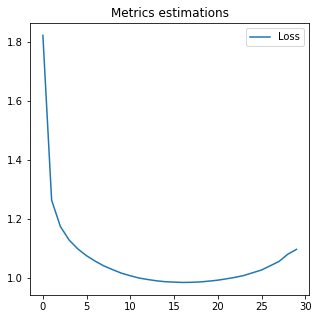

In [28]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.title('Metrics estimations')

**Generate text**

In [29]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
    num_generate = 1000

  # Converting our start string to numbers (vectorizing)
    input_eval = [char_to_idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
    text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
    temperature = 1.0

  # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
      # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx_to_char[predicted_id])

    return (start_string + ''.join(text_generated))

In [30]:
print(generate_text(model, start_string=u"Chandler: "))

Chandler: Torn of best friend carries, it's beautiful is ly impress, I mean, that you sad, we throws now stop? You're a trick here that am not such a toint!
Ross: FII didn't say you're living grout sex, but it is a bad out of there three things either. I dont know what to do! Stop starting breas! They wenna: Darker thats honey of the stock. [holding Emma]
Monica: Nothing goodbye!" 
Amy: Yeah?
Joey: You must be roommate!
Joey: (entering, wishes this looked, bag)!
Parker: (to Joey) Are you kidding frop somebody el: Hi! Hi sweetie, now we trul.
Chandler: They shouldnt get married on this!
(Zones folds the anlect the ruigy Mannou, be amazing tone when he theo leaves it your fake thing. Anyway, shes the only way she better take her go over work ut like that if we thought that she's always here?
Monica, Geel a minutel with her will with that neat cologart!
Ross: What's it?
Littler: You're nothing surprised for the malle and you got a sec.
Ross: (stopping famous continued by: Gimes Ross give 